# Assignment "Assignment" System for DCT Academy's Code Platform

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse as sparse
from sklearn.externals import joblib
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
import random
import requests
import json
import tensorflow as tf

## Creating list of dataframe of all tables, a dictionary mapping to corresponding dataframe

In [2]:
# Dictionary of all the tables and their columns
table_columns = {}

# Dictionary of all dataframes mapped with table names
df_all = {}

# List of all dataframes of all tables
df_list = []

request_tables = ['submissions', 'assignments', 'tags', 'taggings']

for table in request_tables:
    url = 'http://code.dctacademy.com/api/v1/ml/data/' + table + '?key=6eccc23db96ed84fce329e0d20bdacb4'
    response = requests.get(url)
#     print(response.status_code, response.reason)
    df_all[table] = pd.read_json(response.content)
    
model_path = '../ml-api/model/'

## Get all student/user assignments
### Merge submissions, assignments, taggings, tags

In [3]:
user_submissions = df_all['submissions'] \
    .merge(df_all['assignments'], left_on='assignment_id', right_on='id', suffixes=('_submissions', '_assignments')) \
    .merge(df_all['taggings'], left_on='id_assignments', right_on='taggable_id', suffixes=('_sub_ass', '_taggings')) \
    .merge(df_all['tags'], left_on='tag_id', right_on='id', suffixes=('_sub_ass_tag', '_tags')) 

submission_assignments = df_all['submissions'] \
    .merge(df_all['assignments'], left_on='assignment_id', right_on='id', suffixes=('_submissions', '_assignments'))

user_submissions.drop(['statement', 'output', 'language', 'created_at_submissions', 'updated_at_submissions', 'is_checked', 'body', 'url', 
                       'created_at_assignments', 'updated_at_assignments', 'pass', 'fail', 'tagger_type', 'created_at', 'total', 'practice_id', 
                       'assignment_id', 'user_id_assignments', 'code_assignments', 'tagger_id', 'tag_id', 'source', 'input_size',
                       'approved', 'function_name', 'context', 'id_sub_ass_tag', 'taggings_count', 'is_allowed', 'video_url', 'code_submissions', 'display_helper'], axis=1, inplace=True)

In [4]:
user_submissions.columns

Index(['id_submissions', 'points_submissions', 'time_in_seconds',
       'user_id_submissions', 'id_assignments', 'is_front_end', 'minutes',
       'points_assignments', 'title', 'taggable_id', 'taggable_type',
       'id_tags', 'name'],
      dtype='object')

In [5]:
user_submissions.head()

,id_submissions,points_submissions,time_in_seconds,user_id_submissions,id_assignments,is_front_end,minutes,points_assignments,title,taggable_id,taggable_type,id_tags,name
0,5,0.0,0,11,13,False,10,10,Merge two strings,13,Assignment,2,easy
1,4,0.0,0,13,13,False,10,10,Merge two strings,13,Assignment,2,easy
2,13,0.0,0,18,13,False,10,10,Merge two strings,13,Assignment,2,easy
3,14,0.0,0,17,13,False,10,10,Merge two strings,13,Assignment,2,easy
4,12,0.0,0,19,13,False,10,10,Merge two strings,13,Assignment,2,easy


In [6]:
user_submissions.describe().round()

,id_submissions,points_submissions,time_in_seconds,user_id_submissions,id_assignments,minutes,points_assignments,taggable_id,id_tags
count,37696.0,37696.0,37696.0,37696.0,37696.0,37696.0,37696.0,37696.0,37696.0
mean,4332.0,10.0,184401.0,97.0,187.0,15.0,14.0,187.0,17.0
std,2741.0,7.0,934470.0,53.0,155.0,9.0,6.0,155.0,10.0
min,1.0,0.0,-404943.0,3.0,13.0,5.0,10.0,13.0,1.0
25%,1722.0,5.0,457.0,52.0,37.0,10.0,10.0,37.0,10.0
50%,4370.0,10.0,1548.0,84.0,132.0,15.0,10.0,132.0,16.0
75%,6745.0,10.0,19711.0,142.0,348.0,20.0,20.0,348.0,20.0
max,9125.0,50.0,16335600.0,229.0,489.0,60.0,50.0,489.0,41.0


In [7]:
user_submissions.dropna(inplace=True)

In [8]:
user_submissions_low = user_submissions[(user_submissions['time_in_seconds'] < 300)]
user_submissions = user_submissions[(user_submissions['time_in_seconds'] > 300)]

In [9]:
user_submissions.describe().round()

,id_submissions,points_submissions,time_in_seconds,user_id_submissions,id_assignments,minutes,points_assignments,taggable_id,id_tags
count,31308.0,31308.0,31308.0,31308.0,31308.0,31308.0,31308.0,31308.0,31308.0
mean,4450.0,10.0,222954.0,99.0,187.0,16.0,14.0,187.0,17.0
std,2743.0,8.0,1021066.0,53.0,156.0,9.0,7.0,156.0,10.0
min,15.0,0.0,301.0,3.0,13.0,5.0,10.0,13.0,1.0
25%,1898.0,5.0,830.0,54.0,37.0,10.0,10.0,37.0,10.0
50%,4554.0,10.0,2560.0,87.0,131.0,15.0,10.0,131.0,16.0
75%,6874.0,10.0,44604.0,144.0,349.0,20.0,20.0,349.0,22.0
max,9124.0,50.0,16335600.0,222.0,489.0,60.0,50.0,489.0,41.0


In [10]:
user_submissions_low.describe().round()

,id_submissions,points_submissions,time_in_seconds,user_id_submissions,id_assignments,minutes,points_assignments,taggable_id,id_tags
count,6379.0,6379.0,6379.0,6379.0,6379.0,6379.0,6379.0,6379.0,6379.0
mean,3752.0,9.0,-4555.0,87.0,183.0,13.0,12.0,183.0,17.0
std,2654.0,5.0,18123.0,51.0,149.0,6.0,4.0,149.0,10.0
min,1.0,0.0,-404943.0,3.0,13.0,5.0,10.0,13.0,1.0
25%,1330.0,5.0,100.0,46.0,34.0,10.0,10.0,34.0,10.0
50%,3286.0,10.0,171.0,71.0,144.0,10.0,10.0,144.0,16.0
75%,6056.0,10.0,228.0,123.0,343.0,20.0,10.0,343.0,18.0
max,9125.0,50.0,299.0,229.0,487.0,60.0,50.0,487.0,41.0


In [11]:
user_submissions_low.quantile(0.01)

id_submissions            10.0
points_submissions         0.0
time_in_seconds       -85035.0
user_id_submissions        3.0
id_assignments            13.0
is_front_end               0.0
minutes                    5.0
points_assignments        10.0
taggable_id               13.0
id_tags                    2.0
Name: 0.01, dtype: float64

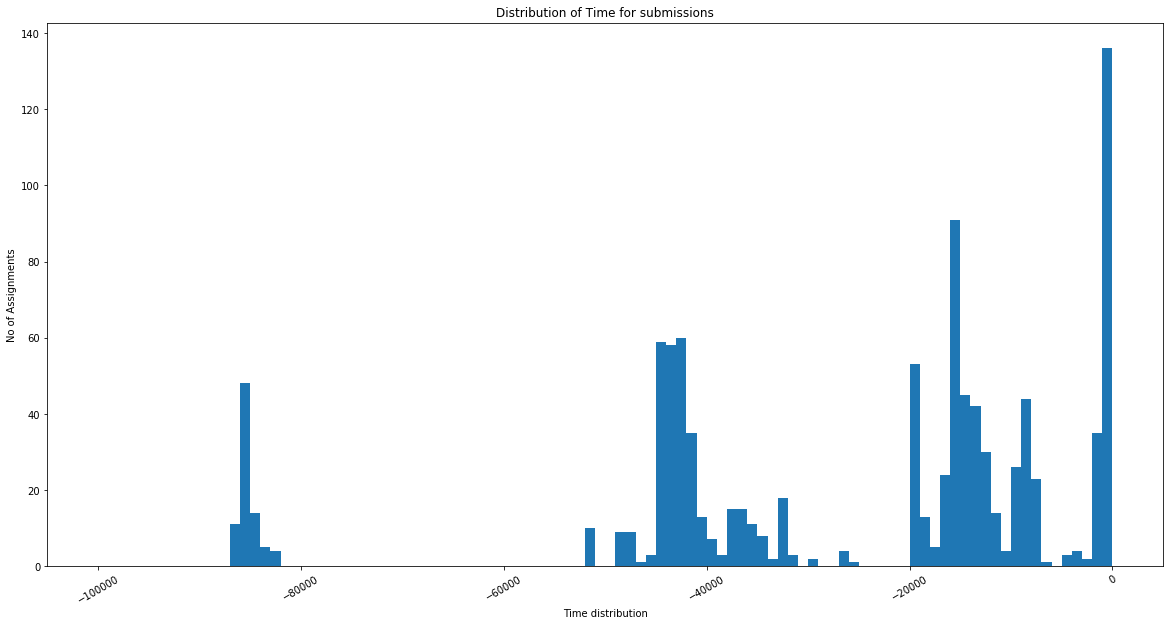

In [12]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='30')
plt.hist(user_submissions_low['time_in_seconds'], bins=np.arange(-100000, 300, 1000))
plt.title('Distribution of Time for submissions')
plt.xlabel('Time distribution')
plt.ylabel('No of Assignments')
plt.show()

In [13]:
user_submissions.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31308 entries, 9 to 37694
Data columns (total 13 columns):
id_submissions         31308 non-null int64
points_submissions     31308 non-null float64
time_in_seconds        31308 non-null int64
user_id_submissions    31308 non-null int64
id_assignments         31308 non-null int64
is_front_end           31308 non-null bool
minutes                31308 non-null int64
points_assignments     31308 non-null int64
title                  31308 non-null object
taggable_id            31308 non-null int64
taggable_type          31308 non-null object
id_tags                31308 non-null int64
name                   31308 non-null object
dtypes: bool(1), float64(1), int64(8), object(3)
memory usage: 3.1+ MB


In [14]:
user_submissions['name'] = user_submissions['name'].str.strip().replace('/',',')

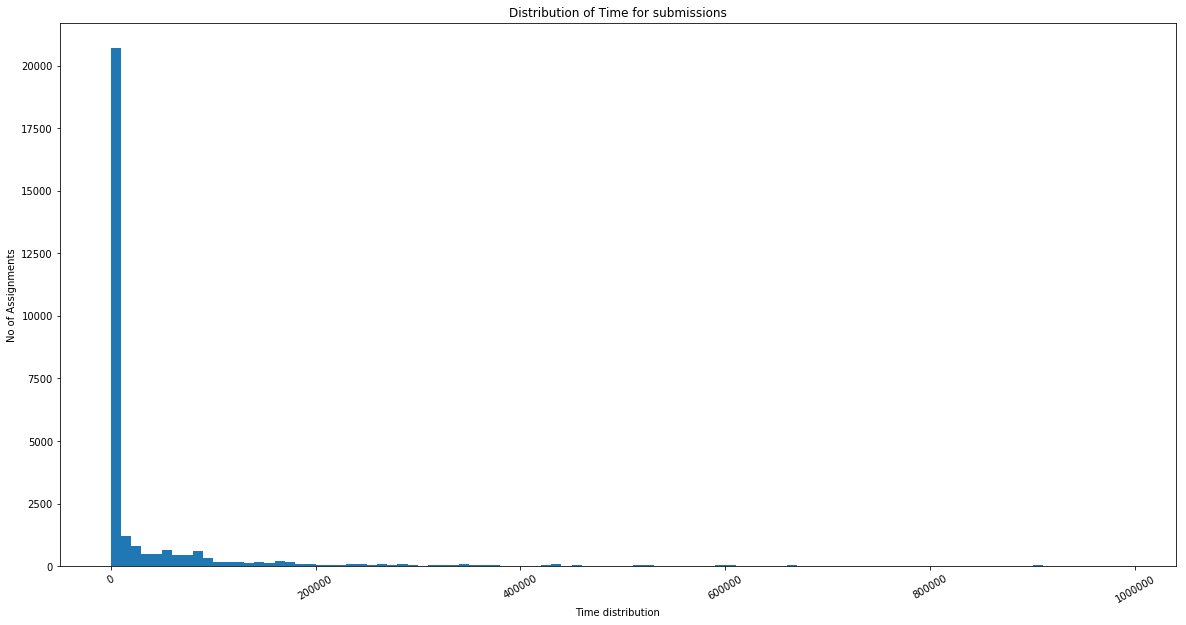

In [15]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='30')
plt.hist(user_submissions['time_in_seconds'], bins=np.arange(0, 1000000, 10000))
plt.title('Distribution of Time for submissions')
plt.xlabel('Time distribution')
plt.ylabel('No of Assignments')
plt.show()

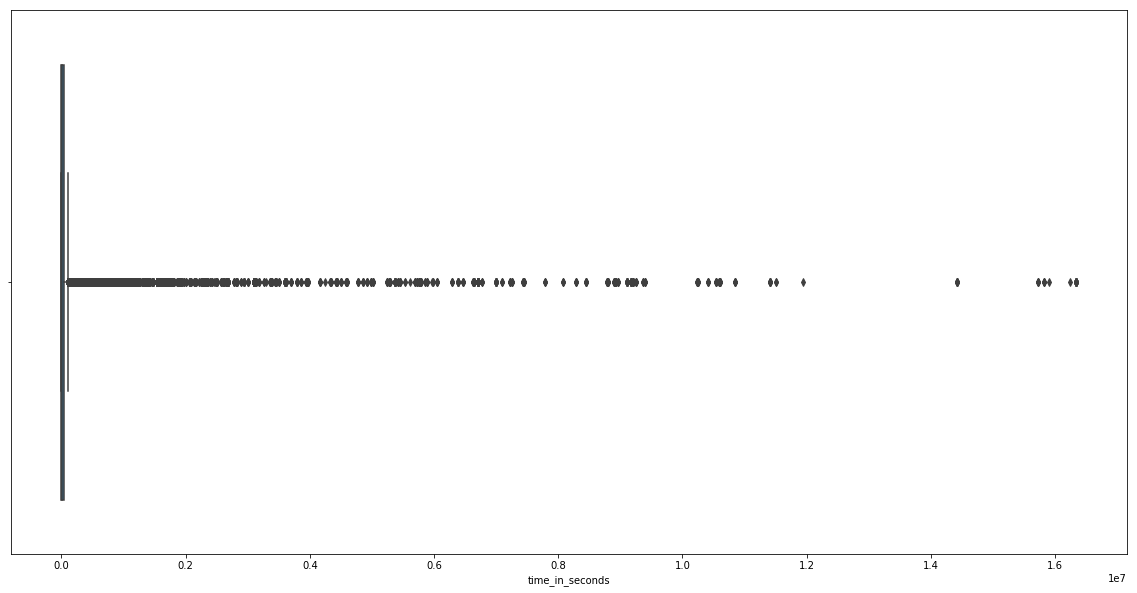

In [16]:
plt.figure(figsize=(20, 10))
sns.boxplot(x=user_submissions['time_in_seconds'])
plt.show()

In [17]:
user_submissions['time_in_seconds'].quantile(0.99)

5377640.0

In [18]:
user_submissions['time_in_seconds'] = user_submissions['time_in_seconds'][user_submissions['time_in_seconds'] < user_submissions['time_in_seconds'].quantile(0.99)]

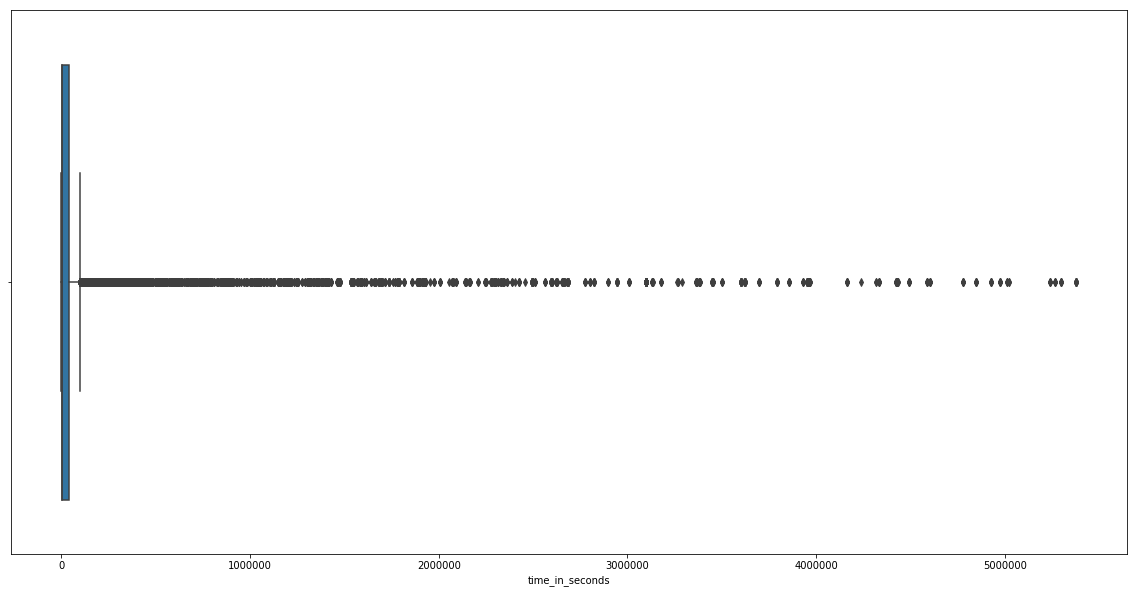

In [19]:
plt.figure(figsize=(20, 10))
sns.boxplot(x=user_submissions['time_in_seconds'])
plt.show()

In [20]:
user_submissions['time_in_seconds'].describe().round()

count      30987.0
mean      136527.0
std       486354.0
min          301.0
25%          825.0
50%         2490.0
75%        40485.0
max      5377516.0
Name: time_in_seconds, dtype: float64

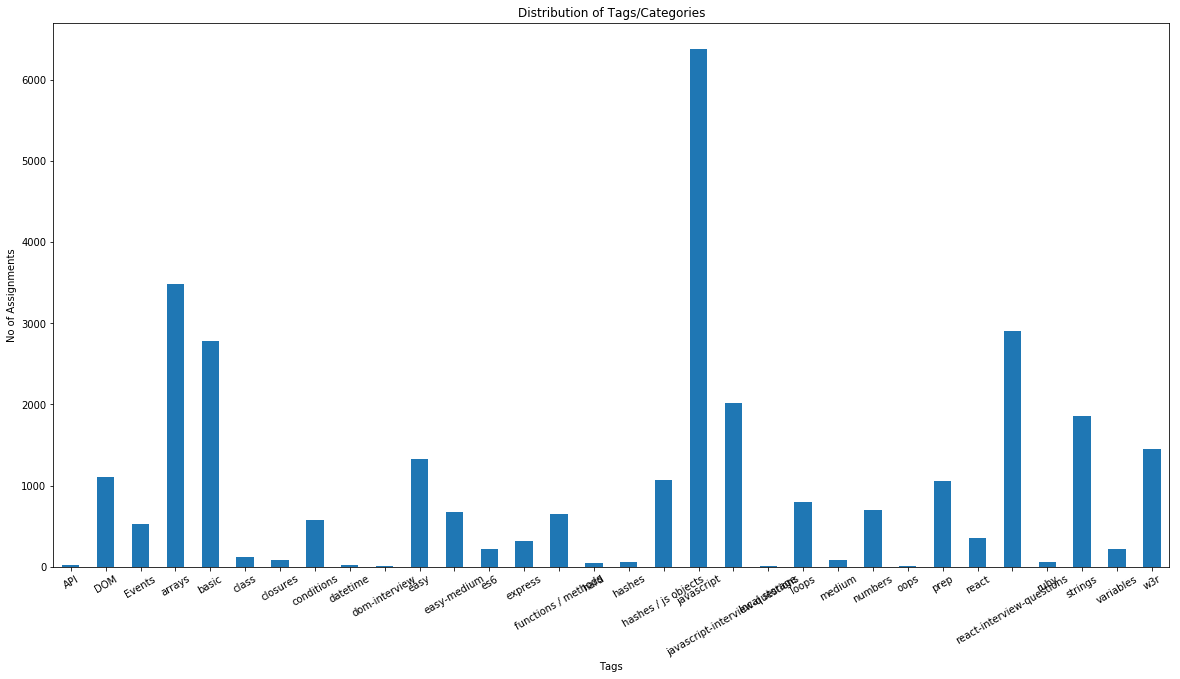

In [21]:
plt.figure(figsize=(20, 10))
user_submissions.groupby(['name']).count()['time_in_seconds'].plot(kind='bar')
plt.xticks(rotation='30')
plt.title('Distribution of Tags/Categories')
plt.xlabel('Tags')
plt.ylabel('No of Assignments')
plt.show()

In [22]:
user_submissions['confidence'] = ((user_submissions['points_submissions'] / user_submissions['points_assignments']) + (user_submissions['minutes'] / (user_submissions['time_in_seconds'] / 60))) * user_submissions['points_assignments']
user_submissions['confidence'] = user_submissions['confidence'].abs()

In [23]:
user_submissions = user_submissions.groupby(['user_id_submissions', 'id_assignments']).sum().reset_index()
user_submissions = user_submissions[['user_id_submissions', 'id_assignments', 'confidence']]
user_submissions.head()

,user_id_submissions,id_assignments,confidence
0,3,23,45.054857
1,3,24,0.000000
2,3,30,103.270014
3,3,31,96.394099
4,3,33,444.444444


In [24]:
user_submissions = user_submissions[user_submissions['confidence'] > user_submissions['confidence'].quantile(0.10)]
user_submissions = user_submissions.reset_index()

In [25]:
user_submissions.head()

,index,user_id_submissions,id_assignments,confidence
0,0,3,23,45.054857
1,2,3,30,103.270014
2,3,3,31,96.394099
3,4,3,33,444.444444
4,5,3,34,191.897655


In [26]:
train, test = train_test_split(user_submissions, test_size=0.2, random_state=42)
n_users = len(user_submissions.user_id_submissions.unique())
n_assignments = len(user_submissions.id_assignments.unique())
print(n_users, n_assignments)

177 239


In [27]:
from tensorflow.keras.layers import Input, Embedding, Flatten, Dot, Dense
from tensorflow.keras import Model

In [28]:
assignment_input = Input(shape=[1], name="assignment-input")
assignment_embedding = Embedding(n_assignments + 1, 5, name="assignment-embedding")(assignment_input)
assignment_vec = Flatten(name="flatten-assignments")(assignment_embedding)

In [29]:
user_input = Input(shape=[1], name="User-Input")
user_embedding = Embedding(n_users+1, 5, name="User-Embedding")(user_input)
user_vec = Flatten(name="Flatten-Users")(user_embedding)

In [30]:
prod = Dot(name="Dot-Product", axes=1)([assignment_vec, user_vec])
model = Model([user_input, assignment_input], prod)
model.compile('adam', 'mean_squared_error')

In [31]:
history = model.fit([train.user_id_submissions, train.id_assignments], train.confidence, epochs=100, verbose=1)
model.save('regression_model.h5')

Epoch 1/100
5115/5115 [==============================] - 0s 80us/sample - loss: 19248.4623
Epoch 2/100
5115/5115 [==============================] - 0s 59us/sample - loss: 19248.1742
Epoch 3/100
5115/5115 [==============================] - 0s 56us/sample - loss: 19246.3648
Epoch 4/100
5115/5115 [==============================] - 0s 61us/sample - loss: 19240.0042
Epoch 5/100
5115/5115 [==============================] - 0s 51us/sample - loss: 19226.7321
Epoch 6/100
5115/5115 [==============================] - 0s 63us/sample - loss: 19206.6780
Epoch 7/100
5115/5115 [==============================] - 0s 50us/sample - loss: 19181.0436
Epoch 8/100
5115/5115 [==============================] - 0s 63us/sample - loss: 19150.8078
Epoch 9/100
5115/5115 [==============================] - 0s 49us/sample - loss: 19116.6812
Epoch 10/100
5115/5115 [==============================] - 0s 59us/sample - loss: 19078.8803
Epoch 11/100
5115/5115 [==============================] - 0s 60us/sample - loss: 19037.81

In [32]:
assignment_em = model.get_layer('assignment-embedding')
assignment_em_weights = assignment_em.get_weights()[0]

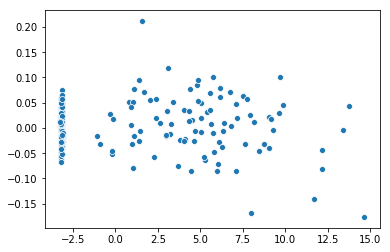

In [33]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(assignment_em_weights)
sns.scatterplot(x=pca_result[:,0], y=pca_result[:,1])

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 240 samples in 0.000s...
[t-SNE] Computed neighbors for 240 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 240 / 240
[t-SNE] Mean sigma: 0.049368
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.333157
[t-SNE] KL divergence after 300 iterations: 0.430143


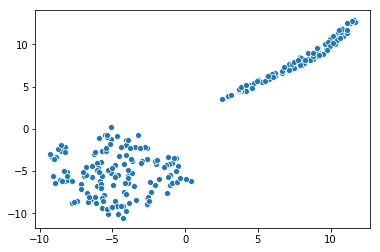

In [34]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tnse_results = tsne.fit_transform(assignment_em_weights)
sns.scatterplot(x=tnse_results[:,0], y=tnse_results[:,1])

In [35]:
assignment_data = np.array(list(set(user_submissions.id_assignments)))
user = np.array([20 for i in range(len(assignment_data))])

In [36]:
predictions = model.predict([user, assignment_data])
predictions = np.array([a[0] for a in predictions])
predictions[:10]

array([ 73.28078   ,  76.01168   ,  52.61131   ,  62.893425  ,
        -0.22288135,  65.573166  , 117.15709   ,  58.907894  ,
        42.38576   , 117.34909   ], dtype=float32)

In [37]:
recommended_assignment_ids = (-predictions).argsort()[:10]
print(recommended_assignment_ids)
print(predictions[recommended_assignment_ids])

[14 15 35  9  6 36 30 76 80 28]
[136.31165  129.2522   126.662766 117.34909  117.15709  113.45998
  99.58593   98.1342    97.79387   95.11186 ]


In [38]:
df_all['assignments'][df_all['assignments']['id'].isin(recommended_assignment_ids)]

,approved,body,code,created_at,display_helper,function_name,id,input_size,is_allowed,is_front_end,minutes,points,source,title,updated_at,url,user_id
1,True,<p>Write a JavaScript function to capitalize t...,DCTdbf3,2018-01-26 11:01:39.880,"{""function_name"":null,""input_size"":null}",None,76,NaN,False,False,10,10,,Capitalize,2018-08-06 15:44:50.298,,3
2,True,<p>Write a converter function that accepts a t...,DCT31db,2018-01-11 04:31:40.426,"{""function_name"":""converter"",""input_size"":1}",converter,14,1.0,False,False,5,10,,Temperature Converter,2018-08-06 15:44:50.307,,44
4,True,<p>Write a function that accepts three argumen...,DCTcce0,2018-01-11 10:06:02.916,"{""function_name"":""oneElementOut"",""input_size"":3}",oneElementOut,28,3.0,False,False,5,10,,Only One,2018-08-06 15:44:50.316,,44
13,True,<p>Create a function&nbsp;<code>sumMultiplyAnd...,DCTa505,2018-01-11 10:11:54.454,"{""function_name"":""sumMultiplyAndRound"",""input_...",sumMultiplyAndRound,36,3.0,False,False,10,10,,Round Town,2018-08-06 15:44:50.372,,3
214,True,<p>Write a simple JavaScript Function to join ...,DCTf933,2018-01-26 11:04:28.073,"{""function_name"":""joinArray"",""input_size"":2}",joinArray,80,2.0,False,False,10,10,,Join Array Elements,2018-08-06 15:44:51.456,,49
340,True,<p>Write the function&nbsp;<code>fizzBuzz</cod...,DCT88e3,2018-01-11 10:11:10.218,"{""function_name"":""fizzBuzz"",""input_size"":1}",fizzBuzz,35,1.0,False,False,10,10,,Fizz Buzz,2018-08-06 15:44:51.611,,3
342,True,<p>Create the function&nbsp;<code>askPolitely<...,DCTe2dc,2018-01-11 09:56:23.615,"{""function_name"":""askPolitely"",""input_size"":1}",askPolitely,15,1.0,False,False,5,10,,Ask Politely,2018-08-06 15:44:51.620,,40
352,True,<p>Write a function&nbsp;<code>zooInventory</c...,DCT0153,2018-01-11 10:07:37.911,"{""function_name"":""zooInventory"",""input_size"":1}",zooInventory,30,1.0,False,False,15,10,,Zoo Inventory,2018-08-06 15:44:51.806,,3
